# Connect Eye-AI and Load Libraries

In [3]:
%load_ext autoreload
%autoreload 2

# # Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / "eye-ai-exec"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Prerequisites
import json
import os

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI
from models.vgg19 import vgg19_diagnosis_train

# ML Analytics
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [5]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-06-11 10:44:24,003 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-11 10:44:24,004 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


# Configuration

In [6]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-06-11 10:44:26,528 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-11 10:44:26,529 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [7]:
source_dataset = "4-S42W"

asset_RID = ["4-MWQ6"]  # VGG19 cropped
#asset_RID = ["4-MWQ8"]  # VGG19 uncropped

preds_workflow = EA.add_workflow( 
    Workflow(
        name="LAC data template",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/Get_VGGPreds.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description="Instance of creating VGG19 predictions",
    )

execution = EA.create_execution(config)

2025-06-11 10:44:27,851 - INFO - Materialize bag 4-S42W... 
2025-06-11 10:44:27,952 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-11 10:44:27,953 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-11 10:44:29,440 - INFO - Using cached bag for  4-S42W Version:0.2.1
2025-06-11 10:44:29,441 - INFO - Loading /data/4-S42W_2c92df824a3b41ec944c1a5dce5c71fd97f72b0fbcbe53d3a229327621274dfd/Dataset_4-S42W
2025-06-11 10:44:29,889 - INFO - Creating new database for dataset: 4-S42W in /data/kb_766/EyeAI_working/4-S42W@33E-APAZ-TTM4.db
2025-06-11 10:44:29,933 - INFO - Downloading assets ...
2025-06-11 10:44:33,839 - INFO - File [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YQJG/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Cropped_2-277G_Feb_14_2025.h5] transfer successful. 227.

In [8]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 4-YQJG
workflow_rid: 4-M4TT
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YQJG/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Cropped_2-277G_Feb_14_2025.h5')]}
configuration: datasets=[DatasetSpec(rid='4-S42W', materialize=True, version=DatasetVersion(major=0, minor=2, patch=1))] assets=['4-MWQ6'] workflow='4-M4TT' parameters={} description='Instance of creating VGG19 predictions' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-06c8048b-8c7e-4a8e-8ebd-a1bdac5d7659.json']


In [9]:
output_dir = execution._working_dir / execution.execution_rid

In [10]:
ds_bag_test = execution.datasets[0]

In [11]:
test_image_path_cropped, test_csv_cropped = EA.create_cropped_images(ds_bag = ds_bag_test,
                                                                     output_dir = output_dir / "dataset" / "test",
                                                                     crop_to_eye =True)

In [12]:
asset_output_dir = execution._working_dir / execution.execution_rid / "asset"
asset_output_dir.mkdir( parents=True, exist_ok=True )

In [13]:
current_date = datetime.now().strftime("%b_%d_%Y") 

In [14]:
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [15]:

with execution.execute() as exec:
        predictions_results, metrics_summary = vgg19_diagnosis_train.evaluate_only(
            model_path = model_path, 
            model_name = f"VGG19_Cropped_Model_{ds_bag_test.dataset_rid}_{current_date}", 
            test_path = test_image_path_cropped, 
            output_dir = asset_output_dir,
            classes = {'No_Glaucoma': 0, 'Suspected_Glaucoma': 1}
        )
        print("Execution Results:")
        print(predictions_results, metrics_summary)

2025-06-11 10:45:38,637 - INFO - Start execution  ...
2025-06-11 10:45:38,728 - INFO - Start execution  ...
2025-06-11 10:45:38.949981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-11 10:45:38.978127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-11 10:45:38.982410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node

Found 656 images belonging to 2 classes.


2025-06-11 10:45:40.619695: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-11 10:45:53,940 - INFO - Predictions saved to VGG19_Cropped_Model_4-S42W_Jun_11_2025_predictions_results.csv
2025-06-11 10:45:53,940 - INFO - Metrics saved to VGG19_Cropped_Model_4-S42W_Jun_11_2025_metrics_summary.csv
2025-06-11 10:45:53,941 - INFO - Successfully run Ml.
2025-06-11 10:45:54,011 - INFO - Algorithm execution ended.


Execution Results:
/data/kb_766/EyeAI_working/4-YQJG/asset/VGG19_Cropped_Model_4-S42W_Jun_11_2025_predictions_results.csv /data/kb_766/EyeAI_working/4-YQJG/asset/VGG19_Cropped_Model_4-S42W_Jun_11_2025_metrics_summary.csv


In [16]:
pd.read_csv( metrics_summary )

,Metric,Value
0,F1 Score,0.756345
1,Precision,0.663697
2,Recall,0.879056
3,Accuracy,0.707317
4,ROC-AUC,0.817733


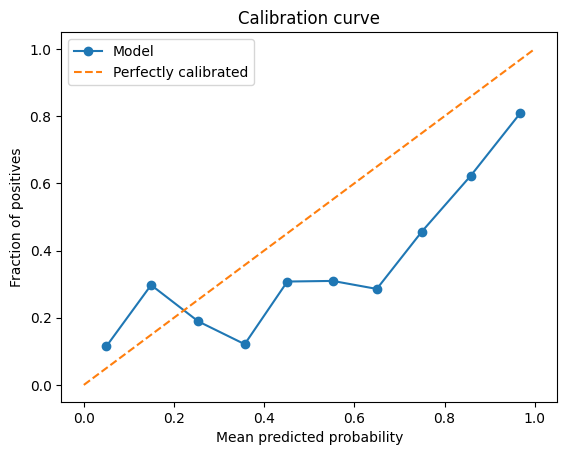

In [20]:
# Calibration curve
preds = pd.read_csv( predictions_results )

prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

In [38]:
# Gather patient data

preds['Image'] = preds['Filename'].apply(lambda x: x.split("_")[2].split(".")[0])

# Link to diagnosis data
linkdDF = pd.merge( preds,
    ds_bag_test.get_table_as_dataframe('Image_Diagnosis')[['Image','Diagnosis_Image']],
    on = 'Image', how = 'left' 
)

# Link to image data
linkdDF = pd.merge( linkdDF,
                   ds_bag_test.get_table_as_dataframe('Image')[['RID', 'Observation']],
                   left_on = 'Image', right_on = 'RID', 
                   how = 'left')
linkdDF = linkdDF.drop('RID', axis = 1)

# Link to observation data
linkdDF = pd.merge( linkdDF,
                   ds_bag_test.get_table_as_dataframe('Observation')[['RID', 'Subject']],
                   left_on = 'Observation', right_on = 'RID', 
                   how = 'left')
linkdDF = linkdDF.drop('RID', axis = 1)

linkdDF = pd.merge( linkdDF,
                   ds_bag_test.get_table_as_dataframe('Subject')[['RID', 'Subject_Gender', 'Subject_Ethnicity']],
                   left_on = 'Subject', right_on = 'RID', 
                   how = 'left')
linkdDF = linkdDF.drop('RID', axis = 1)

linkdDF['Subject_Ethnicity'] = linkdDF['Subject_Ethnicity'].astype('category')


In [46]:
linkdDF['Subject_Gender'].value_counts()/656, linkdDF['Subject_Ethnicity'].value_counts()/656

(Subject_Gender
 M    0.603659
 F    0.373476
 N    0.022866
 Name: count, dtype: float64,
 Subject_Ethnicity
 Asian                      0.256098
 African Descent            0.228659
 ethnicity not specified    0.179878
 Other                      0.178354
 Caucasian                  0.157012
 Name: count, dtype: float64)

In [56]:
# Explore performance metrics

# Confirm AUC
fpr, tpr, thresholds = roc_curve( preds["True Label"], preds["Probability Score"])
print( "Overall AUC" )
print( auc(fpr, tpr) )

# Check AUC by ethnicity
for e in pd.unique( linkdDF['Subject_Ethnicity'] ):
    tDF = linkdDF[ linkdDF['Subject_Ethnicity'] == e ]
    fpr, tpr, thresholds = roc_curve( tDF["True Label"], tDF["Probability Score"])
    print( e )
    print( auc(fpr, tpr) )

# Check AUC by gender
for g in pd.unique( linkdDF['Subject_Gender'] ):
    tDF = linkdDF[ linkdDF['Subject_Gender'] == g ]
    fpr, tpr, thresholds = roc_curve( tDF["True Label"], tDF["Probability Score"])
    print( g )
    print( auc(fpr, tpr) )

Overall AUC
0.8177326149465398
African Descent
0.8128561253561254
Caucasian
0.7978080120937265
Other
0.8331385154880186
ethnicity not specified
0.7979885057471264
Asian
0.8468749999999999
M
0.8109370215372053
F
0.8286554397219995
N
0.8392857142857143


In [62]:
linkdDF[ (linkdDF[ 'Diagnosis_Image' ] == 'Suspected Glaucoma') & (linkdDF[ 'Prediction' ] == 0) ]

,Filename,True Label,Prediction,Probability Score,Image,Diagnosis_Image,Observation,Subject,Subject_Gender,Subject_Ethnicity
326,Suspected_Glaucoma/Cropped_2-CXM8.JPG,1.0,0,0.192375,2-CXM8,Suspected Glaucoma,2-CNB0,2-CMXR,N,ethnicity not specified
329,Suspected_Glaucoma/Cropped_2-CXT8.JPG,1.0,0,0.476227,2-CXT8,Suspected Glaucoma,2-CNC0,2-CK7Y,M,Asian
330,Suspected_Glaucoma/Cropped_2-CXTC.JPG,1.0,0,0.052002,2-CXTC,Suspected Glaucoma,2-CNC0,2-CK7Y,M,Asian
347,Suspected_Glaucoma/Cropped_2-CY9C.JPG,1.0,0,0.491940,2-CY9C,Suspected Glaucoma,2-CNEJ,2-CJ7C,M,Other
355,Suspected_Glaucoma/Cropped_2-CYEC.JPG,1.0,0,0.451641,2-CYEC,Suspected Glaucoma,2-CNFC,2-CK3E,M,Other
412,Suspected_Glaucoma/Cropped_2-D0GM.JPG,1.0,0,0.065349,2-D0GM,Suspected Glaucoma,2-CNTG,2-CK36,M,Other
413,Suspected_Glaucoma/Cropped_2-D0GP.JPG,1.0,0,0.098549,2-D0GP,Suspected Glaucoma,2-CNTG,2-CK36,M,Other
435,Suspected_Glaucoma/Cropped_2-D1FT.JPG,1.0,0,0.426740,2-D1FT,Suspected Glaucoma,2-CNZP,2-CFXJ,M,Caucasian
440,Suspected_Glaucoma/Cropped_2-D1RW.JPG,1.0,0,0.300748,2-D1RW,Suspected Glaucoma,2-CP18,2-CG4P,M,Caucasian
446,Suspected_Glaucoma/Cropped_2-D27M.JPG,1.0,0,0.144418,2-D27M,Suspected Glaucoma,2-CP3M,2-CN9A,F,African Descent


# Upload Results

In [118]:
# # crete asset path
# asset_type_name = "Diagnosis_Analysis"
# asset_path = exec.execution_asset_path(asset_type_name)

# # save assets to asset_path
# linkdDF.to_csv(asset_path/'ImagesToVGG19.csv', index=False)

# upload assets to catalog
exec.upload_execution_outputs(clean_folder=True)

2025-03-24 16:16:09,766 - INFO - Initializing uploader: GenericUploader v1.7.6 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-03-24 16:16:09,767 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-03-24 16:16:09,767 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-03-24 16:16:09,804 - INFO - Scanning files in directory [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C]...
2025-03-24 16:16:09,805 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C/execution-metadata/Execution_Config/configuration.json].
2025-03-24 16:16:09,806 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C/execution-metadata/Runtime_Env/environment_snapshot_ytvbrm53.txt].
2025-03-24

{'Execution_Config/configuration.json': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/c574c9dbd4d2f1c98a1120b20c9c2b3a.configuration.json:dzyDIqTmdshSDmojKAIzT8JYnBDH1Mdx', 'RID': '4-S4R0', 'RCT': '2025-03-24T23:16:10.356903+00:00', 'RMT': '2025-03-24T23:16:10.356903+00:00', 'RCB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'RMB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'Filename': 'configuration.json', 'Description': None, 'Length': 226, 'MD5': 'c574c9dbd4d2f1c98a1120b20c9c2b3a', 'Execution_Metadata_Type': 'Execution_Config'}, rid='4-S4R0'),
 'Runtime_Env/environment_snapshot_ytvbrm53.txt': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/4bdd399d7cc638e1bb0e992d330c240b.environment_snapshot_ytvbrm53.txt:yPxwkhgeO6Ub5AcWr6kVDY8hvXhRfPpx', 'RID': '4-S4R2', 'RCT': '2025-03-24T23:16:10.635156+00:00', 'RMT': '2025-03-24T2